# Reverend Bayes updates our Believe in Flood Detection
**How an 275 year old idea helps map the extent of floods**

In [1]:
%matplotlib widget

import numpy as np

from tuw_education_notebooks.view_bayes_flood import view_bayes_flood
from tuw_education_notebooks.calc_bayes_flood import sig0_dc, calc_likelihoods, plot_posteriors

import ipywidgets as widgets
from eomaps import Maps

# From Backscattering to Flood Mapping

This notebook explains how microwave $\sigma^0$ backscattering (Figure 1) can be used to map the extent of a flood. You can click on the figure to see streets and cities.

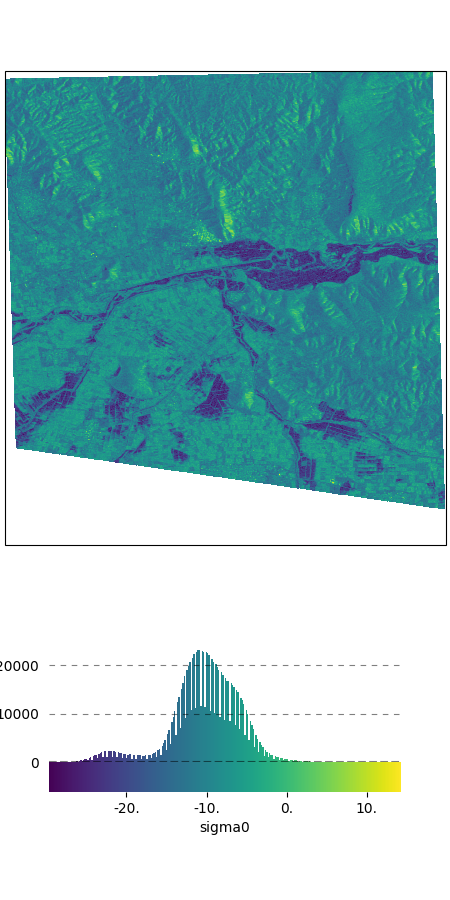

In [2]:
m = Maps(layer="data", figsize=(4.5, 9))
m.set_data(data=sig0_dc, x="x", y="y", parameter="SIG0", crs=sig0_dc.spatial_ref.crs_wkt)
m.plot_map()
m.add_colorbar(label="sigma0")
m2 = m.new_layer(layer="map")
m2.add_wms.OpenStreetMap.add_layer.default()
m.all.cb.click.attach.peek_layer(layer="data|map", how=0.5)
m.show()

## Microwave Backscattering over Land and Water

Reverend Bayes was concerned with two events, one "the hypothesis" occurring before the other "the evidence". If we know the cause it easy to logically deduce the probability of an effect. But in this case we want to deduce the probability of a cause from an observed effect, also know as "reversed probability". In the case of flood mapping we have $\sigma^0$ backscatter observations over land (effect) and we want to deduce the probability of flooding (F) and non-flooding (NF). 

Phrased differently we want to know the probability of flooding given a pixel's $\sigma^0$:

$$P(F|\sigma^0)$$

and the probability of a pixel being not flooded given a certain $\sigma^0$:

$$P(NF|\sigma^0)$$

Bayes showed that these can be deduced from the from the observation that forward and reversed probability are equal, so that:

$$P(F|\sigma^0)P(\sigma^0) = P(\sigma^0|F)P(F)$$

The forward probability of $\sigma^0$ given flood ($P(\sigma^0|F)$) and $\sigma^0$ given non-flood ($P(\sigma^0|NF)$) can be extracted from past information on backscattering over land and water surfaces. As seen in the figure below the characteristic of backscattering over land and water.

![Image taken from Geological Survey Ireland](https://www.gsi.ie/images/images/SAR_mapping_land_water.jpg)

## Likelihoods

These so-called likelihood of $P(\sigma^0|F)$ and $P(\sigma^0|NF)$ can thus be calculated from past backscattering information.

In [3]:
pixel = widgets.IntSlider(value=0, min=0, max=sig0_dc.SIG0.size)
pixel

IntSlider(value=0, max=1209000)

Without going into the details of how these likelihoods are calculated, you can move the slider to show the likelihoods of \sigma^0 being governed by land or water for each pixel of Figure 1. In the figure below likelihoods are calculated over a range of $\sigma^0$ and the pixel's observed $\sigma^0$ is given with a vertical line.

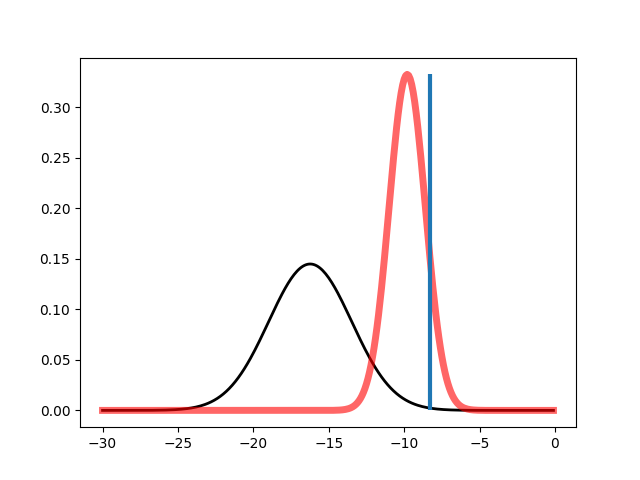

In [4]:
water_likelihood, land_likelihood = calc_likelihoods(pixel.value, x = [-30, 0], plot=True)

Recalculate the last two cells two see the likelihoods for different pixels of the study area (figure 1).

## Posteriors

Having the likelihoods calculate we can now move on to calculate the probability of (non-)flooding given a pixel's $\sigma^0$. These so-called "posteriors" need on more piece of information as can be seen in the equation above. We need the probability whether a pixel is flooded $P(F)$ or non-flooded $P(NF)$. We can of course not know this information, so our best estimate is that change are 50-50. This subjective prior believe is a fundament of Bayesian statistics and we use it to updated our believe in a particular hypothesis. We now can also calculate the probability of backscattering $P(\sigma^0)$, as the weighted average of the water and land likelihoods. The latter ensures that our updated evidence (or posteriors) range between 0 to 1.

The following code block show how we calculate the priors.

In [5]:
def calc_posteriors(water_likelihood, land_likelihood):
    evidence = (water_likelihood * 0.5) + (land_likelihood * 0.5)
    return (water_likelihood * 0.5) / evidence,  (land_likelihood * 0.5) / evidence

We can plot these posteriors again and compare these to pixels measured \sigma^0 (vertical line).

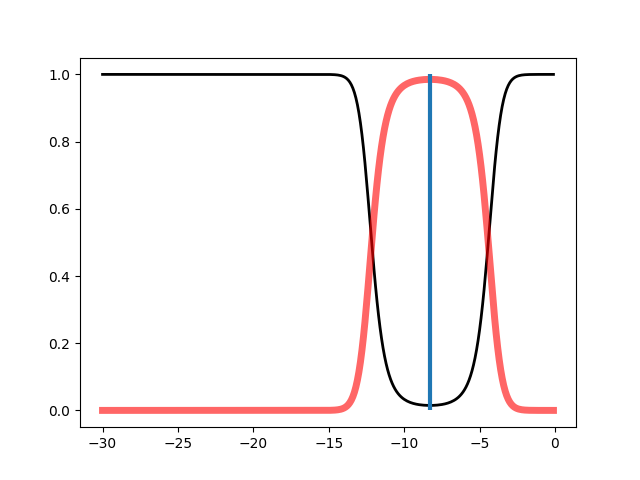

In [6]:
f_post_prob, nf_post_prob = calc_posteriors(water_likelihood, land_likelihood)
plot_posteriors(pixel.value, f_post_prob, nf_post_prob, x=[-30, 0])

## Flood Classification

We are now ready to combine all this information and classify the pixels according to the probability of flooding given the backscaterr value.

In [7]:
def bayesian_flood_decision(id, sig0_dc):
    f_post_prob, nf_post_prob = calc_posteriors(*calc_likelihoods(id,  sig0_dc))
    return np.greater(nf_post_prob, f_post_prob)

Here we can see a single value.

In [8]:
sig0 = sig0_dc.SIG0.where(sig0_dc.id==pixel.value, drop=True)
sig0

<xarray.DataArray 'SIG0' (y: 1, x: 1)> Size: 8B
array([[-8.3]])
Coordinates:
  * x        (x) float64 8B 5.661e+06
  * y        (y) float64 8B 6.42e+05
Attributes: (12/30)
    abs_orbit_number:       20802
    AREA_OR_POINT:          Area
    border_noise_removed:   True
    creation_date:          2021-07-19 19:54:09
    creator:                gfm_ops
    dem_source:             /eodc/private/jrc_gfm/gfm_scratch/copdem/CopDEM30...
    ...                     ...
    worker_git_tag:         from v1.0.0 to v1.1.0
    worker_name:            s1-sigma
    wrapper_git_commit:     none
    wrapper_git_tag:        v1.0.0
    wrapper_name:           gfm-sigma-offline
    grid_mapping:           spatial_ref

In [9]:
bayesian_flood_decision(pixel.value, sig0)

array([ True])

And now the whole area. Click a point on the plot to see the likelihoods and posterior distributions.

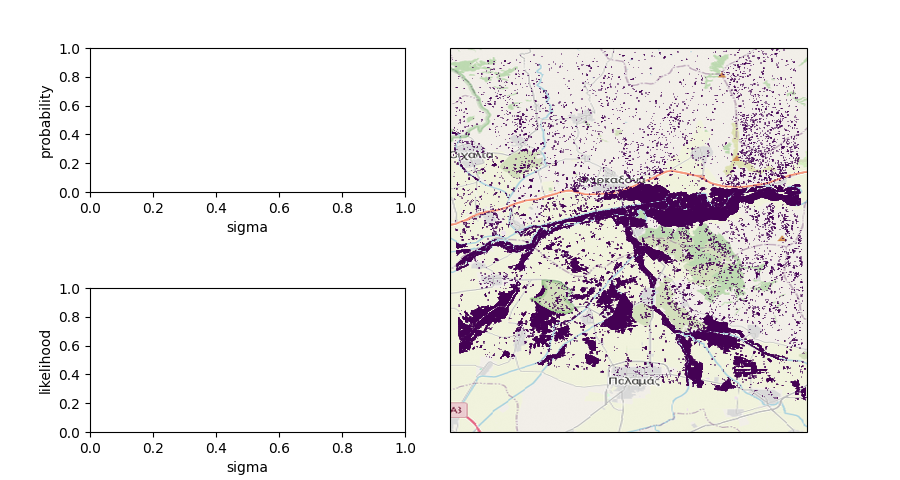

In [10]:
view_bayes_flood(sig0_dc, calc_posteriors, bayesian_flood_decision)